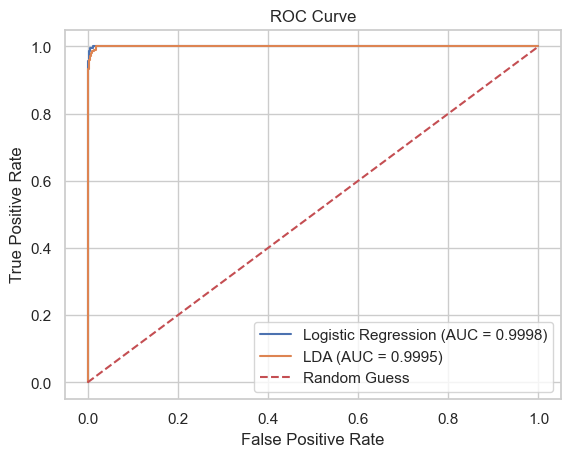


Logistic Regression
Accuracy: 0.9950
Confusion Matrix:
[[393   2]
 [  1 204]]
ROC AUC: 0.9998

LDA
Accuracy: 0.9633
Confusion Matrix:
[[373  22]
 [  0 205]]
ROC AUC: 0.9995

Best Performing Model: Logistic Regression


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Load data
file_path = "./mental_health_workplace_survey.csv"
data = pd.read_csv(file_path)

#  Outlier Removal 
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

for col in ['WorkHoursPerWeek', 'SleepHours', 'StressLevel']:
    data = remove_outliers_iqr(data, col)

#  Target and Features 
X = data.drop(["StressLevel", "EmployeeID", "BurnoutRisk"], axis=1)
y = data["BurnoutRisk"]

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# Handle missing values
categorical_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_features = [col for col in X_train.columns if col not in categorical_features]

for col in categorical_features:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_valid[col].fillna(X_train[col].mode()[0], inplace=True)

for col in numerical_features:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_valid[col].fillna(X_train[col].median(), inplace=True)

# Encode categorical variables
encoder = OrdinalEncoder()
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
X_valid[categorical_features] = encoder.transform(X_valid[categorical_features])

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

#  Model Training 
models = {
    "Logistic Regression": LogisticRegression(),
    "LDA": LinearDiscriminantAnalysis()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    y_proba = model.predict_proba(X_valid_scaled)[:, 1]
    
    acc = accuracy_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)
    
    results[name] = {"Accuracy": acc, "Confusion Matrix": cm, "ROC AUC": roc_auc}
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")  #From GFG

# Plot formatting
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#  Result Summary
for name, metrics in results.items():
    print(f"\n{name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")

best_model = max(results.items(), key=lambda x: x[1]['ROC AUC'])[0]
print(f"\nBest Performing Model: {best_model}")
